In [2]:
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
import download
from random import shuffle
from keras.applications import VGG16
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense, Activation
import sys
import h5py

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [3]:
def print_progress(count, max_count):
    pct_complete = count / max_count
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

In [4]:
def download_data(in_dir, url):
    
    if not os.path.exists(in_dir):
        os.makedirs(in_dir)
    
    download.maybe_download_and_extract(url,in_dir)

In [5]:
in_dir = "data"

In [6]:
url_hockey = "http://visilab.etsii.uclm.es/personas/oscar/FightDetection/HockeyFights.zip"

In [7]:
download_data(in_dir,url_hockey)

Data has apparently already been downloaded and unpacked.


In [8]:
img_size = 224

img_size_touple = (img_size, img_size)

num_channels = 3

img_size_flat = img_size * img_size * num_channels

num_classes = 2

_num_files_train = 1

_images_per_file = 20

_num_images_train = _num_files_train * _images_per_file

video_exts = ".avi"

In [9]:
def get_frames(current_dir, file_name):
    
    in_file = os.path.join(current_dir, file_name)
    
    images = []
    
    vidcap = cv2.VideoCapture(in_file)
    
    success,image = vidcap.read()
        
    count = 0

    while count<_images_per_file:
                
        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)
    
        images.append(res)
    
        success,image = vidcap.read()
    
        count += 1
        
    result = np.array(images)
    
    result = (result / 255.).astype(np.float16)
        
    return result

In [10]:
def label_video_names(in_dir):
    
    names = []
    
    labels = []
    
    for current_dir, dir_names,file_names in os.walk(in_dir):
        
        for file_name in file_names:
            
            if file_name[0:2] == 'fi':
                labels.append([1,0])
                names.append(file_name)
            elif file_name[0:2] == 'no':
                labels.append([0,1])
                names.append(file_name)
                             
    c = list(zip(names,labels))
    shuffle(c)
    
    names, labels = zip(*c)
            
    return names, labels

In [45]:
names, labels = label_video_names(in_dir)

In [46]:
frames = get_frames(in_dir, names[12])

In [47]:
visible_frame = (frames*255).astype('uint8')

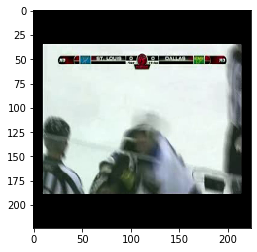

In [48]:
plt.imshow(visible_frame[3])

In [33]:
image_model = VGG16(include_top=True, weights='imagenet')

In [21]:
image_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [22]:
input_shape = image_model.layers[0].output_shape[1:3]
input_shape

(224, 224)

In [23]:
transfer_layer = image_model.get_layer('fc2')

image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

transfer_values_size = K.int_shape(transfer_layer.output)[1]


print("The input of the VGG16 net have dimensions:",K.int_shape(image_model.input)[1:3])

print("The output of the selecter layer of VGG16 net have dimensions: ", transfer_values_size)

The input of the VGG16 net have dimensions: (224, 224)
The output of the selecter layer of VGG16 net have dimensions:  4096


In [24]:
def get_transfer_values(current_dir, file_name):
    
    shape = (_images_per_file,) + img_size_touple + (3,)
    
    image_batch = np.zeros(shape=shape, dtype=np.float16)
    
    image_batch = get_frames(current_dir, file_name)
    
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    transfer_values = \
            image_model_transfer.predict(image_batch)
            
    return transfer_values

In [25]:
def proces_transfer(vid_names, in_dir, labels):
    
    count = 0
    
    tam = len(vid_names)

    shape = (_images_per_file,) + img_size_touple + (3,)
    
    while count<tam:
        
        video_name = vid_names[count]
        
        image_batch = np.zeros(shape=shape, dtype=np.float16)
    
        image_batch = get_frames(in_dir, video_name)
        
        
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        
        transfer_values = \
            image_model_transfer.predict(image_batch)
         
        labels1 = labels[count]
        
        aux = np.ones([20,2])
        
        labelss = labels1*aux
        
        yield transfer_values, labelss
        
        count+=1

In [26]:
def make_files(n_files):
    
    gen = proces_transfer(names_training, in_dir, labels_training)

    numer = 1

    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('proof.h5', 'w') as f:
    
        
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [27]:
def make_files_test(n_files):
    
    gen = proces_transfer(names_test, in_dir, labels_test)

    numer = 1

    chunk = next(gen)

    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]
    
    with h5py.File('proofvalidation.h5', 'w') as f:
    
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]
    
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)
    
        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)
    
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        for chunk in gen:
            
            if numer == n_files:
            
                break

            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]
            
            print_progress(numer, n_files)
        
            numer += 1

In [28]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [31]:
make_files(training_set)

- Progress: 99.9%

In [ ]:
make_files_test(test_set)

In [33]:
def process_alldata_training():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('proof.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [34]:
def process_alldata_test():
    
    joint_transfer=[]
    frames_num=20
    count = 0
    
    with h5py.File('proofvalidation.h5', 'r') as f:
            
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    for i in range(int(len(X_batch)/frames_num)):
        inc = count+frames_num
        joint_transfer.append([X_batch[count:inc],y_batch[count]])
        count =inc
        
    data =[]
    target=[]
    
    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))
        
    return data, target

In [35]:
data, target = process_alldata_training()

In [36]:
data_test, target_test = process_alldata_test()

In [37]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

In [38]:
epoch = 20
batchS = 500

history = model.fit(np.array(data[0:750]), np.array(target[0:750]), epochs=epoch,
                    validation_data=(np.array(data[750:]), np.array(target[750:])), 
                    batch_size=batchS, verbose=2)
result = model.evaluate(np.array(data_test), np.array(target_test))

Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Train on 750 samples, validate on 50 samples
Epoch 1/20
 - 6s - loss: 0.3169 - accuracy: 0.4907 - val_loss: 0.3307 - val_accuracy: 0.4800
Epoch 2/20
 - 5s - loss: 0.2928 - accuracy: 0.5147 - val_loss: 0.2706 - val_accuracy: 0.5200
Epoch 3/20
 - 5s - loss: 0.2734 - accuracy: 0.4907 - val_loss: 0.2503 - val_accuracy: 0.4800
Epoch 4/20
 - 5s - loss: 0.2532 - accuracy: 0.5093 - val_loss: 0.2587 - val_accuracy: 0.4800
Epoch 5/20
 - 5s - loss: 0.2508 - accuracy: 0.5093 - val_loss: 0.2447 - val_accuracy: 0.5200
Epoch 6/20
 - 5s - loss: 0.2470 - accuracy: 0.4907 - val_loss: 0.2441 - val_accuracy: 0.5200
Epoch 7/20
 - 5s - loss: 0.2459 - accuracy: 0.4907 - val_loss: 0.2387 - val_accuracy: 0.8400
Epoch 8/20
 - 5s - loss: 0.2376 - accuracy: 0.7360 - val_loss: 0.2391 - val_accuracy: 0.4800
Epoch 9/20
 - 5s - loss: 0.2341 - accuracy: 0.5173 - val_loss: 0.2238 - val_accuracy: 0.8400
Epoch 10/20
 - 5s - loss: 0.2227 - accuracy: 0.8693 - val_loss: 0.2066 - val_accuracy: 0.8800
Epoch 11/20
 - 5s - loss

In [39]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.10631074637174606
accuracy 0.8650000095367432


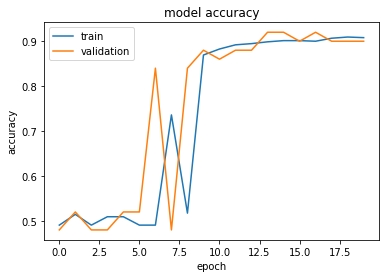

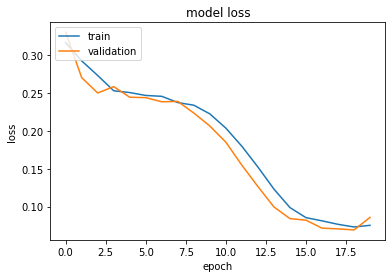

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

In [30]:
for i in range(1,10):
    video = get_transfer_values('data1', 'fi{}_xvid.avi'.format(i))
    video = video.reshape((1, video.shape[0], video.shape[1]))
#label = np.argmax(model.predict(video))
    l = model.predict(video)
    if float(l[0][0])>float(l[0][1]):
        print("The video named fi{}_xvid.avi is voilent".format(i))
    else:
        print("The video named fi{}_xvid.avi is non-voilent".format(i))

NameError: name 'model' is not defined